In [10]:
import time
import os
import sys
import numpy as np

#import ipympl
import matplotlib
matplotlib.use('nbagg')
#from matplotlib import style
#style.use('ggplot')

import matplotlib.pyplot as plt

import astropy.units as u
from astropy import stats
from astropy.io import fits
from mmtwfs.wfs import *
from mmtwfs.zernike import *
from mmtwfs.telescope import MMT

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
plt.close('all')
mmirs = WFSFactory(wfs="mmirs")
f9wfs = WFSFactory(wfs="newf9", pup_offset=[0.3, 0.])
f5wfs = WFSFactory(wfs="f5")

<IPython.core.display.Javascript object>


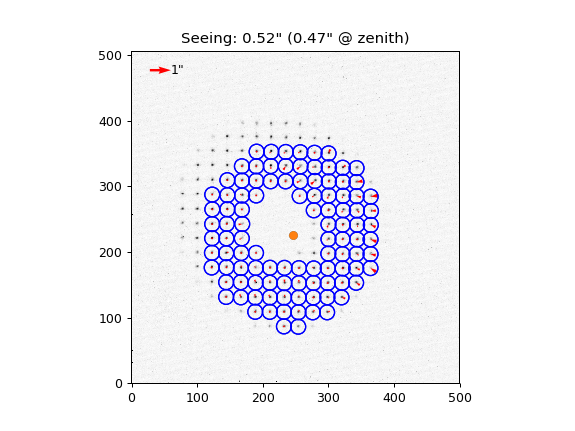

In [4]:
mmirs_file = "/Users/tim/MMT/mmtwfs/mmtwfs/data/test_data/mmirs_wfs_0150.fits"
mmirs_results = mmirs.measure_slopes(mmirs_file, plot=True)
mmirs_results['figures']['slopes'].show()

<IPython.core.display.Javascript object>


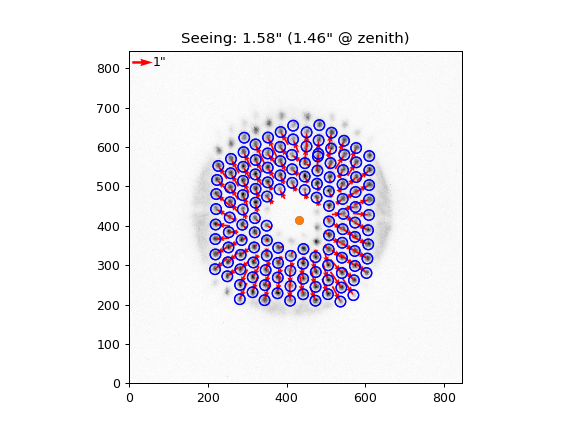

In [15]:
f9_file = "/Users/tim/MMT/mmtwfs/mmtwfs/data/test_data/test_newf9.fits"
f9_results = f9wfs.measure_slopes(f9_file, 'blue', plot=True)
f9_results['figures']['slopes'].show()

<IPython.core.display.Javascript object>


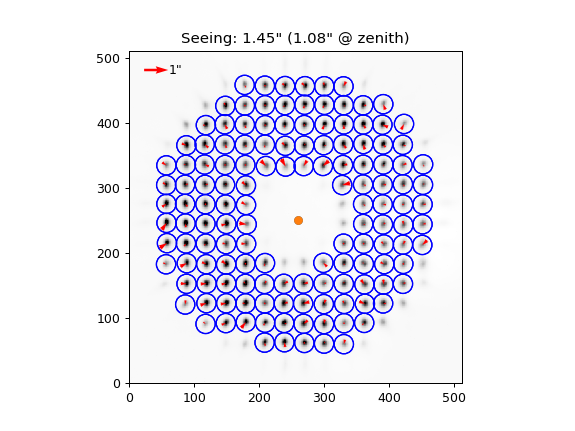

In [6]:
f5_file = "/Users/tim/MMT/mmtwfs/mmtwfs/data/test_data/auto_wfs_0037_ave.fits"
f5_results = f5wfs.measure_slopes(f5_file, 'hecto', plot=True)
f5_results['figures']['slopes'].show()

In [7]:
plt.close('all')

In [8]:
def ZernikeGrad(Z, x, y, atype):

    m1, n1 = x.shape
    m2, n2 = y.shape
    if(m1 != m2 or n1 != n2):
        print('x & y are not the same size')

    if(len(Z) > 22):
        print('ZernikeGrad() is not implemented with >22 terms')
        return
    elif len(Z) < 22:
        Z = np.hstack((Z, np.zeros(22 - len(Z))))

    x2 = x * x
    y2 = y * y
    xy = x * y
    r2 = x2 + y2

    if (atype == 'dx'):
        d = Z[0] * 0 * x  # to make d an array with the same size as x
        d = d + Z[1] * 1
        d = d + Z[2] * 0
        d = d + Z[3] * np.sqrt(3) * 4 * x
        d = d + Z[4] * np.sqrt(6) * 2 * y
        d = d + Z[5] * np.sqrt(6) * 2 * x
        d = d + Z[6] * np.sqrt(8) * 6 * xy
        d = d + Z[7] * np.sqrt(8) * (9 * x2 + 3 * y2 - 2)
        d = d + Z[8] * np.sqrt(8) * 6 * xy
        d = d + Z[9] * np.sqrt(8) * (3 * x2 - 3 * y2)
        d = d + Z[10] * np.sqrt(5) * 12 * x * (2 * (x2 + y2) - 1)
        d = d + Z[11] * np.sqrt(10) * x * (16 * x2 - 6)
        d = d + Z[12] * np.sqrt(10) * y * (24 * x2 + 8 * y2 - 6)
        d = d + Z[13] * np.sqrt(10) * 4 * x * (x2 - 3 * y2)
        d = d + Z[14] * np.sqrt(10) * 4 * y * (3 * x2 - y2)
        d = d + Z[15] * np.sqrt(12) * (
            x2 * (50.0 * x2 + 60.0 * y2 - 36.0) + y2 * (10.0 * y2 - 12.0) + 3)
        d = d + Z[16] * np.sqrt(12) * (xy * (40.0 * r2 - 24.0))
        d = d + Z[17] * np.sqrt(12) * (
            x2 * (25.0 * x2 - 12.0 - 30.0 * y2) + y2 * (12.0 - 15.0 * y2))
        d = d + Z[18] * np.sqrt(12) * (4.0 * xy *
                                       (-6.0 + 15.0 * x2 + 5.0 * y2))
        d = d + Z[19] * np.sqrt(12) * 5 * (x2 * (x2 - 6 * y2) + y2 * y2)
        d = d + Z[20] * np.sqrt(12) * 20 * xy * (x2 - y2)
        d = d + Z[21] * np.sqrt(7) * 24 * x * (
            1 + x2 * (10 * y2 - 5 + 5 * x2) + y2 * (5 * y2 - 5))

    elif (atype, 'dy'):

        d = Z[0] * 0 * x
        d = d + Z[1] * 2 * 0
        d = d + Z[2] * 2 * 1
        d = d + Z[3] * np.sqrt(3) * 4 * y
        d = d + Z[4] * np.sqrt(6) * 2 * x
        d = d + Z[5] * np.sqrt(6) * (-2) * y
        d = d + Z[6] * np.sqrt(8) * (3 * x2 + 9 * y2 - 2)
        d = d + Z[7] * np.sqrt(8) * 6 * xy
        d = d + Z[8] * np.sqrt(8) * (3 * x2 - 3 * y2)
        d = d + Z[9] * np.sqrt(8) * (-6) * xy
        d = d + Z[10] * np.sqrt(5) * 12 * y * (2 * (x2 + y2) - 1)
        d = d + Z[11] * np.sqrt(10) * y * (6 - 16 * y2)
        d = d + Z[12] * np.sqrt(10) * x * (8 * x2 + 24 * y2 - 6)
        d = d + Z[13] * np.sqrt(10) * 4 * y * (y2 - 3 * x2)
        d = d + Z[14] * np.sqrt(10) * 4 * x * (x2 - 3 * y2)
        d = d + Z[15] * np.sqrt(12) * (xy * (40.0 * r2 - 24.0))
        d = d + Z[16] * np.sqrt(12) * (
            x2 * (10.0 * x2 + 60.0 * y2 - 12.0) + y2 * (50.0 * y2 - 36.0) + 3)
        d = d + Z[17] * np.sqrt(12) * (4.0 * xy * (6.0 - 5.0 * x2 - 15.0 * y2))
        d = d + Z[18] * np.sqrt(12) * (
            y2 * (-25.0 * y2 + 12.0 + 30.0 * x2) + x2 * (-12.0 + 15.0 * x2))
        d = d + Z[19] * np.sqrt(12) * 20 * xy * (y2 - x2)
        d = d + Z[20] * np.sqrt(12) * 5 * (x2 * (x2 - 6 * y2) + y2 * y2)
        d = d + Z[21] * np.sqrt(7) * 24 * y * (
            1 + y2 * (10 * x2 - 5 + 5 * y2) + x2 * (5 * x2 - 5))

    return d

In [16]:
noll_coefficient(4)

1.7320508075688772

In [17]:
np.sqrt(3)

1.7320508075688772